In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout, Flatten,TimeDistributed
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


stock_data = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Total_Data/shift_kospi_sen_all.csv')
stock_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,research_kospi,Kospi_open,Kospi_high,Kospi_low,Kospi_close,Kospi_vol,dji_open,dji_high,dji_low,...,oil_low,oil_close,oil_vol,ko_interest,ko_consumer,ko_real_estate,kofinbert_score_summarize_content_kospi,kofinbert_score_title_kospi,klue_bert_score_summarize_content,klue_bert_score_title
0,20210105,0.413,0.765,0.795,0.770,2990.57,0.232,0.632,0.638,0.647,...,0.225,0.220,0.013,0.0,0.137,0.911,0.157,0.195,-0.536,0.823
1,20210106,0.628,0.802,0.819,0.799,2968.21,0.388,0.641,0.667,0.657,...,0.230,0.222,0.006,0.0,0.137,0.911,1.236,0.569,1.381,0.722
2,20210107,0.427,0.830,0.839,0.820,3031.68,0.474,0.671,0.677,0.689,...,0.236,0.228,0.007,0.0,0.137,0.911,0.537,1.395,1.845,-0.675
3,20210108,0.512,0.823,0.855,0.830,3152.18,0.389,0.681,0.674,0.683,...,0.242,0.239,0.004,0.0,0.137,0.911,0.697,-1.382,2.497,1.124
4,20210111,0.881,0.855,0.914,0.862,3148.45,0.318,0.677,0.672,0.685,...,0.242,0.236,0.009,0.0,0.137,0.911,0.331,-0.044,-0.951,0.730


In [ ]:
def accuracy(list1,list2):
  list1 = list1.flatten().tolist()
  list2 = list2.flatten().tolist()
  value_1 = []
  value_2 = []
  j = 0
  if len(list1) == len(list2):
    for i in range(len(list1)-1):
      if list1[i+1] > list1[i]:
        value_1.append(1)
      elif list1[i+1] == list1[i]:
        value_1.append(0)
      else:
        value_1.append(-1)
    for i in range(len(list1)-1):
      if list2[i+1] > list2[i]:
        value_2.append(1)
      elif list2[i+1] == list2[i]:
        value_2.append(0)
      else:
        value_2.append(-1)
    for i in range(len(value_1)):
      if value_1[i] == value_2[i]:
        j = j + 1
    accuracy = j/len(value_1) * 100
    print("accuracy : %d" % accuracy)
  else:
    print("길이가 다릅니다.")

# ORG_VERSION

In [ ]:
org_col = [i for i in list(stock_data.columns) if 'gold' in i or 'oil' in i or 'ex' in i or 'Kospi' in i]
org_col.append('klue_bert_score_title')
print(org_col)

org_stock_data = stock_data[org_col]

# 데이터 전처리
data = org_stock_data['Kospi_close'].values.reshape(-1, 1)
org_stock_data = org_stock_data.drop(['Kospi_close'],axis=1)

['Kospi_open', 'Kospi_high', 'Kospi_low', 'Kospi_close', 'Kospi_vol', 'ex_AM_open', 'ex_AM_high', 'ex_AM_low', 'ex_AM_close', 'ex_JP_open', 'ex_JP_high', 'ex_JP_low', 'ex_JP_close', 'gold_open', 'gold_high', 'gold_low', 'gold_close', 'gold_vol', 'oil_open', 'oil_high', 'oil_low', 'oil_close', 'oil_vol', 'klue_bert_score_title']


In [ ]:
# 데이터 분할
train_size = int(len(data) * 0.85)
train_data, test_data = data[:train_size], data[train_size:]
train_data_t_1, test_data_t_1 = org_stock_data[:train_size], org_stock_data[train_size:]

def create_dataset(dataset, data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 5  # 몇 일 동안의 데이터를 사용할 것인지 설정

trainX, trainY = create_dataset(train_data_t_1, train_data, look_back)
testX, testY = create_dataset(test_data_t_1,test_data, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(494, 5, 23)
(494, 1)
(84, 5, 23)
(84, 1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 1024)           4292608   
                                                                 
 dropout_7 (Dropout)         (None, 5, 1024)           0         
                                                                 
 lstm_8 (LSTM)               (None, 5, 512)            3147776   
                                                                 
 dropout_8 (Dropout)         (None, 5, 512)            0         
                                                                 
 lstm_9 (LSTM)               (None, 5, 256)            787456    
                                                                 
 dropout_9 (Dropout)         (None, 5, 256)            0         
                                                                 
 lstm_10 (LSTM)              (None, 5, 128)           

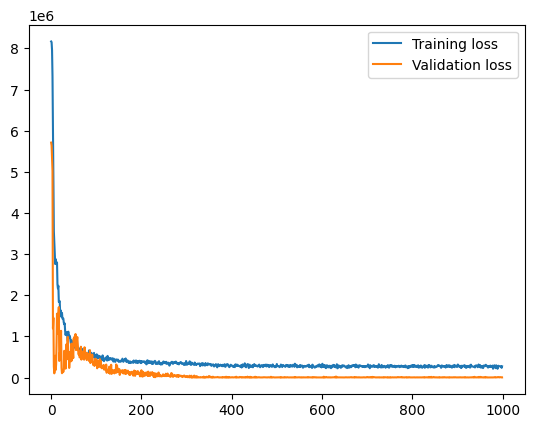

3/3 [==============================] - 0s 9ms/step
Training MSE: 22986.14440148432
Testing MSE: 12201.714859131826
accuracy : 60


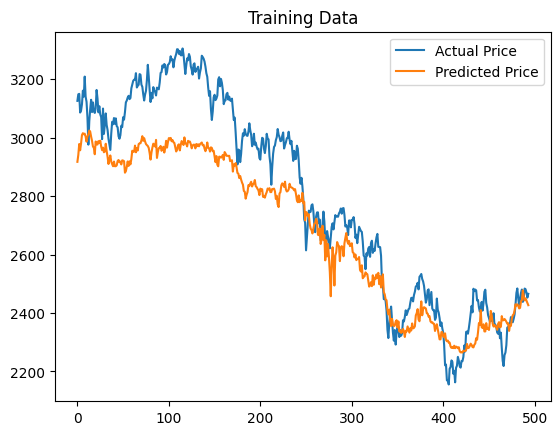

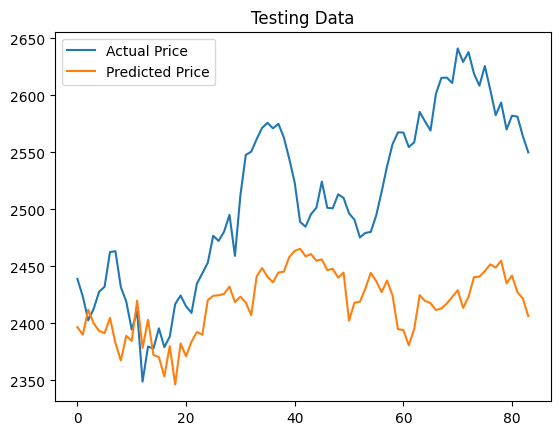

In [ ]:
# 모델 생성 LSTM
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./ko_sum_LSTM_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

accuracy(testPredict,testY)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

# New_Our_VERSION

In [ ]:
del_col = [i for i in list(stock_data.columns) if 'dji' in i or 'score' in i]
del_col.append('Date')

In [ ]:
new_col = list(set(stock_data.columns) - set(del_col))
new_col.append('klue_bert_score_title')

In [ ]:
new_stock_data = stock_data[new_col]

# 데이터 전처리
data = new_stock_data['Kospi_close'].values.reshape(-1, 1)
new_stock_data = new_stock_data.drop(['Kospi_close'],axis=1)

In [ ]:
# 데이터 분할
train_size = int(len(data) * 0.85)
train_data, test_data = data[:train_size], data[train_size:]
train_data_t_2, test_data_t_2 = new_stock_data[:train_size], new_stock_data[train_size:]

def create_dataset(dataset, data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 5  # 몇 일 동안의 데이터를 사용할 것인지 설정

trainX, trainY = create_dataset(train_data_t_2, train_data, look_back)
testX, testY = create_dataset(test_data_t_2,test_data, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(494, 5, 32)
(494, 1)
(84, 5, 32)
(84, 1)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 5, 1024)           4329472   
                                                                 
 dropout_42 (Dropout)        (None, 5, 1024)           0         
                                                                 
 lstm_43 (LSTM)              (None, 5, 512)            3147776   
                                                                 
 dropout_43 (Dropout)        (None, 5, 512)            0         
                                                                 
 lstm_44 (LSTM)              (None, 5, 256)            787456    
                                                                 
 dropout_44 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_45 (LSTM)              (None, 5, 128)           

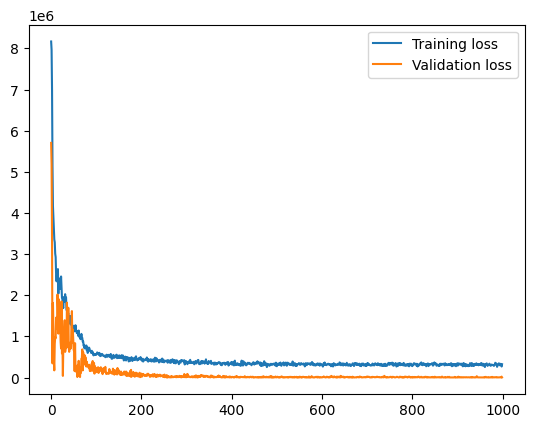

3/3 [==============================] - 0s 9ms/step
Training MSE: 8279.21503382005
Testing MSE: 11964.970333447509
accuracy : 63


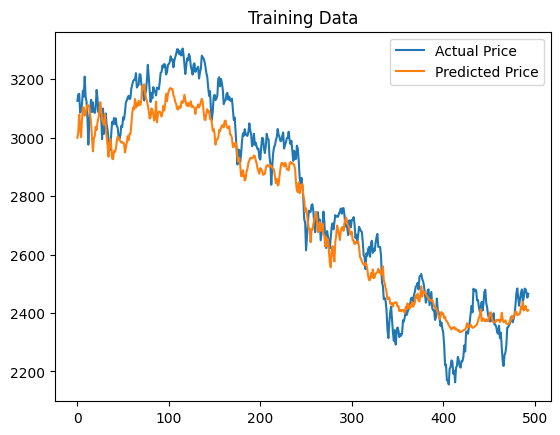

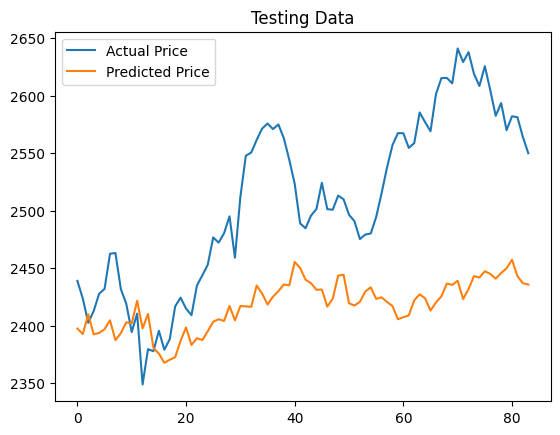

In [ ]:
# 모델 생성 LSTM
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./ko_sum_LSTM_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

accuracy(testPredict,testY)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [ ]:
'''
dji
us500
ex_AM
ex_JP
gold
oil
ko_interest
ko_consumer
ko_real_estate
'''